### Data Cleaning Notebook: For a dataset with zipcode as rows, we did dummied the ratings and Price.
### For the categories I used countvectorizer to assign the matrix to the original data set.
### As the Countvecrizer does not perform well, I saved the data with two copies, one with countvecrizer one without

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin


import pickle
import folium

In [98]:
df= pd.read_csv('../data/03_data_income.csv')
df.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [99]:
df['zip_code'] = df['zip_code'].astype(str)
df.dtypes

id               object
latitude        float64
longitude       float64
price             int64
review_count    float64
rating          float64
zip_code         object
city             object
alias            object
category         object
med_agi           int64
avg_agi           int64
count             int64
dtype: object

In [100]:
df_pivot = df.pivot_table(index='zip_code').reset_index()

In [101]:
df_pivot.to_csv('../data/data_zipcode_j.csv')

In [102]:
X = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code'])
y = df['med_agi']
X.head()

,latitude,longitude,price,review_count,rating,category
0,33.911154,-117.881259,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,33.911959,-117.867374,1,22.0,3.0,['sandwiches']
2,33.911283,-117.867449,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,33.911431,-117.865941,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,33.932860,-117.916253,2,231.0,4.0,['italian']


## Making custom transformers: Adjusted Price

Different types of businesses will have a different distribution of price ranges depending on the product or service they provide. For example, a taco shop with a price rating of '$$' is actually relatively expensive, whereas a sushi restaurant with the same rating is quite common. We hypothesize that a neighborhood with expensive taco shops might be more affluent than a neighborhood with average-priced sushi restaurants; more generally, neighborhoods with disproportionately expensive businessess might be more wealthy than those with just objectively expensive businesses.

In [103]:
print(df[df['category'].str.contains('tacos')]['price'].mean())
print(df[df['category'].str.contains('sushi')]['price'].mean())

1.2374581939799332
2.0346938775510206


We introduce the idea of an adjusted price, which has the goal of scaling a listing's price relative to the overall expensiveness of its parent category. We will calculate the adjusted price by looking at businesses category-by-category and standard scaling the listed price to the mean of that category.

Since we do not want to have any data leakage, we can only apply this transformation on our training data set. Therefore, it is inappropriate to engineer this feature at this stage.

In [104]:
oh = OneHotEncoder(categories='auto', sparse=False)
ohdata = oh.fit_transform(X[['rating']])
ohfeatures = oh.get_feature_names()
oh_df = pd.DataFrame(ohdata, columns=ohfeatures)
oh_df.head()

,x0_0.0,x0_1.0,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,x0_4.0,x0_4.5,x0_5.0
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [105]:
X['rating']

0        3.5
1        3.0
2        3.5
3        2.5
4        4.0
        ... 
28107    4.0
28108    4.5
28109    4.0
28110    4.0
28111    4.5
Name: rating, Length: 28112, dtype: float64

In [106]:
# # https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# # https://www.slideshare.net/PyData/julie-michelman-pandas-pipelines-and-custom-transformers
# # https://gist.github.com/tdpetrou/6a97304dd4452a53be98e4f4e93196e6
# # https://stackoverflow.com/questions/44408861/

# class CategoryPricerReviewer(BaseEstimator, TransformerMixin):
    
#     def __init__(self):
#         self.pcv = None
#         self.rcv = None
        
#     def fit(self, X, y=None):
#         self.pcv = CountVectorizer().fit(X['category'])
#         self.rcv = CountVectorizer().fit(X['category'])
#         return self
            
#     def transform(self, X, y=None):     
        
#         catpri_cols = ['cat_pri_' + s for s in self.pcv.get_feature_names()]
#         catrat_cols = ['cat_rat_' + s for s in self.rcv.get_feature_names()]
        
#         C = self.pcv.transform(X['category']).toarray()
#         D = self.rcv.transform(X['category']).toarray()
        
#         for i in range(len(C)):
#             C[i] = C[i] * X['price'].values[i]
            
#         for j in range(len(D)):
#             D[j] = D[j] * X['rating'].values[j]
        
#         Cdf = pd.DataFrame(C, columns=catpri_cols, index=X.index)
#         Cdf.replace(0, np.NaN, inplace=True)
        
#         Ddf = pd.DataFrame(D, columns=catrat_cols, index=X.index)
#         Ddf.replace(0, np.NaN, inplace=True)
        
#         X = X.join(Cdf)
#         X = X.join(Ddf)
        
#         return X

In [107]:
class StandardizerAndCategoryReducer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.sc = None
        
    def fit(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        self.sc = StandardScaler().fit(X[num_cols])
        return self
            
    def transform(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        cat_cols = [col for col in X.columns if X[col].dtype == 'O']
        cluster_cols = [col for col in X.columns if 'cluster' in col]
        
        S = self.sc.transform(X[num_cols])
        Sdf = pd.DataFrame(S, columns=num_cols, index=X.index)
        catpri_cols = [col for col in X.columns if 'cat_pri_' in col]
        catrat_cols = [col for col in X.columns if 'cat_rat_' in col]
        
        Sdf.loc[:, 'price_adj'] = Sdf.loc[:, catpri_cols].mean(axis=1)
        Sdf.loc[:, 'rating_adj'] = Sdf.loc[:, catrat_cols].mean(axis=1)
        Sdf.drop(columns=catpri_cols + catrat_cols, inplace=True)
        
        X = X.loc[:, cat_cols + cluster_cols].join(Sdf)
        X.drop(columns='category', inplace=True)
        
        return X

In [108]:
# https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# https://www.slideshare.net/PyData/julie-michelman-pandas-pipelines-and-custom-transformers
# https://gist.github.com/tdpetrou/6a97304dd4452a53be98e4f4e93196e6
# https://stackoverflow.com/questions/44408861/

class CategoryPricer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.pcv = None
        
    def fit(self, X, y=None):
        self.pcv = CountVectorizer().fit(X['category'])
        return self
            
    def transform(self, X, y=None):     
        
        catpri_cols = ['cat_pri_' + s for s in self.pcv.get_feature_names()]
        
        C = self.pcv.transform(X['category']).toarray()
        
        for i in range(len(C)):
            C[i] = C[i] * X['price'].values[i]
        
        Cdf = pd.DataFrame(C, columns=catpri_cols, index=X.index)
        Cdf.replace(0, np.NaN, inplace=True)
        
        X = X.join(Cdf)
        
        return X

In [109]:
class StandardizerAndCategoryReducer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.sc = None
        
    def fit(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        self.sc = StandardScaler().fit(X[num_cols])
        return self
            
    def transform(self, X, y=None):
        num_cols = [col for col in X.describe().columns if 'cluster' not in col]
        cat_cols = [col for col in X.columns if X[col].dtype == 'O']
        cluster_cols = [col for col in X.columns if 'cluster' in col]
        
        S = self.sc.transform(X[num_cols])
        Sdf = pd.DataFrame(S, columns=num_cols, index=X.index)
        catpri_cols = [col for col in X.columns if 'cat_pri_' in col]
        
        Sdf.loc[:, 'price_adj'] = Sdf.loc[:, catpri_cols].mean(axis=1)
        Sdf.drop(columns=catpri_cols, inplace=True)
        
        X = X.loc[:, cat_cols + cluster_cols].join(Sdf)
        X.drop(columns='category', inplace=True)
        
        return X

## Transfer learning: KMeans

## attempt at a pipeline

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=111)

In [111]:
preprocessor = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])
Z_train = preprocessor.fit_transform(X_train)
Z_train.head()

,latitude,longitude,price,review_count,rating,price_adj
11130,-0.158758,-0.083118,-0.834990,-0.579423,-3.186599,-0.960900
22783,-1.589489,0.595342,-0.834990,-0.364631,-0.724279,-0.602790
25724,-0.669540,0.825886,0.899315,-0.192797,1.122461,0.897473
1210,0.920793,-1.450279,0.899315,-0.381337,1.122461,0.875899
13717,-1.329370,-0.684204,0.899315,0.079273,1.122461,0.737111


In [112]:
Z_train.dtypes

latitude        float64
longitude       float64
price           float64
review_count    float64
rating          float64
price_adj       float64
dtype: object

In [113]:
Z_test = preprocessor.transform(X_test)
Z_test.isna().sum()

latitude        0
longitude       0
price           0
review_count    0
rating          0
price_adj       0
dtype: int64

In [114]:
# Z_test[Z_test['rating_adj'].isna()]

In [115]:
X_test[X_test.index == 24267]

,latitude,longitude,price,review_count,rating,category
24267,34.048286,-118.330391,1,0.0,0.0,"['coffee', 'grocery']"


## clustering

In [116]:
X.shape

(28112, 6)

In [117]:
y.shape

(28112,)

In [118]:
def transfer_tune(X, y, k):
    
    # get location data from un-pivoted dataframe
    location_data = X[["latitude", "longitude"]]
    
    # instantiate KMeans
    km = KMeans(n_clusters=k)
    
    # fit
    km.fit(location_data)
    
    # insert 'cluster' column with predicted cluster based on k
    X.loc[:, 'cluster'] = km.predict(location_data)
    
    # create dummy columns for cluster
    X_dummy = pd.get_dummies(columns=['cluster'], data=X)
    
    # train-test split on new dummy dataframe
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=111, test_size=0.3
    )
    
    prep = Pipeline([
        ('catpri', CategoryPricer()),
        ('sacr', StandardizerAndCategoryReducer())
    ])
    
    Z_train = prep.fit_transform(X_train)
    Z_test = prep.transform(X_test)
    
    model = LinearRegression()
    model.fit(Z_train, y_train)
    r2 = model.score(Z_test, y_test)
    print(r2)
    # print score vs. k
    return r2

In [119]:
def transfer_tune_iterator(X, y, somelist):
    
    k_dict = dict()
    
    for k in somelist:
        r2 = transfer_tune(X, y, k)
        k_dict[str(k)] = r2
        
    k_df = pd.DataFrame(k_dict, index = [0]).T
    
    return k_df.sort_values(by=0, ascending=False)

## just going to see if i can make anything right now

In [120]:
df.head()

,id,latitude,longitude,price,review_count,rating,zip_code,city,alias,category,med_agi,avg_agi,count
0,zzvkb4J_sQAk8N20OWdZhg,33.911154,-117.881259,2,1257.0,3.5,92821,Brea,lucilles-smokehouse-bar-b-que-brea,"['bbq', 'smokehouse', 'southern']",86070,106163,170
1,zWs68lBY2PyNOTRJhxXapg,33.911959,-117.867374,1,22.0,3.0,92821,Brea,subway-restaurants-brea-4,['sandwiches'],86070,106163,170
2,zOYNwoDjpg6Ehwn0RKX9qA,33.911283,-117.867449,2,367.0,3.5,92821,Brea,nekter-juice-bar-brea,"['juicebars', 'acaibowls', 'icecream']",86070,106163,170
3,zNNLl821AlzApHYqRxNALw,33.911431,-117.865941,1,84.0,2.5,92821,Brea,arbys-brea-2,"['sandwiches', 'hotdogs']",86070,106163,170
4,zJ4pvxtpo3Y5LvylLXmCzA,33.932860,-117.916253,2,231.0,4.0,92821,Brea,portofino-trattoria-brea,['italian'],86070,106163,170


In [121]:
X = df.drop(columns=['avg_agi', 'med_agi', 'count', 'city', 'id', 'alias', 'zip_code', 'longitude', 'latitude'])
y = df['med_agi']
X.head()

,price,review_count,rating,category
0,2,1257.0,3.5,"['bbq', 'smokehouse', 'southern']"
1,1,22.0,3.0,['sandwiches']
2,2,367.0,3.5,"['juicebars', 'acaibowls', 'icecream']"
3,1,84.0,2.5,"['sandwiches', 'hotdogs']"
4,2,231.0,4.0,['italian']


In [122]:
location_data = df[["latitude", "longitude"]]
km = KMeans(n_clusters=300, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

prep = Pipeline([
    ('catpri', CategoryPricer()),
    ('sacr', StandardizerAndCategoryReducer())
])

Z_train = prep.fit_transform(X_train)
Z_test = prep.transform(X_test)

lr = LinearRegression()
lr.fit(Z_train, y_train)
r2 = lr.score(Z_test, y_test)
print (r2)

-5.988798562762279e+21


In [123]:
pd.set_option('display.max_rows', 500)

In [163]:
list(Z_train.columns)

['cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9',
 'cluster_10',
 'cluster_11',
 'cluster_12',
 'cluster_13',
 'cluster_14',
 'cluster_15',
 'cluster_16',
 'cluster_17',
 'cluster_18',
 'cluster_19',
 'cluster_20',
 'cluster_21',
 'cluster_22',
 'cluster_23',
 'cluster_24',
 'cluster_25',
 'cluster_26',
 'cluster_27',
 'cluster_28',
 'cluster_29',
 'cluster_30',
 'cluster_31',
 'cluster_32',
 'cluster_33',
 'cluster_34',
 'cluster_35',
 'cluster_36',
 'cluster_37',
 'cluster_38',
 'cluster_39',
 'cluster_40',
 'cluster_41',
 'cluster_42',
 'cluster_43',
 'cluster_44',
 'cluster_45',
 'cluster_46',
 'cluster_47',
 'cluster_48',
 'cluster_49',
 'cluster_50',
 'cluster_51',
 'cluster_52',
 'cluster_53',
 'cluster_54',
 'cluster_55',
 'cluster_56',
 'cluster_57',
 'cluster_58',
 'cluster_59',
 'cluster_60',
 'cluster_61',
 'cluster_62',
 'cluster_63',
 'cluster_64',
 'cluster_65',
 'cluster_66',
 'clu

In [125]:
coef_dict = dict(zip(Z_train.columns, lr.coef_))
coef_df = pd.DataFrame(coef_dict.items(), columns=['feature', 'coef'])
coef_df

,feature,coef
0,cluster_0,-1.451395e+04
1,cluster_1,9.881636e+03
2,cluster_2,1.443743e+04
3,cluster_3,2.498729e+04
4,cluster_4,3.334032e+04
5,cluster_5,-3.130051e+04
6,cluster_6,-2.082676e+04
7,cluster_7,-4.083336e+04
8,cluster_8,-9.778794e+03
9,cluster_9,1.888815e+04


In [126]:
y_pred = lr.predict(Z_test)

In [127]:
residuals = y_test - y_pred

Text(0.5, 1.0, 'Residual Mean')

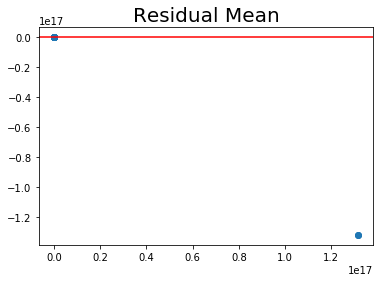

In [128]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)

In [175]:
pickle.dump(lr, open('../flask_app_complete/model.p', 'wb'))

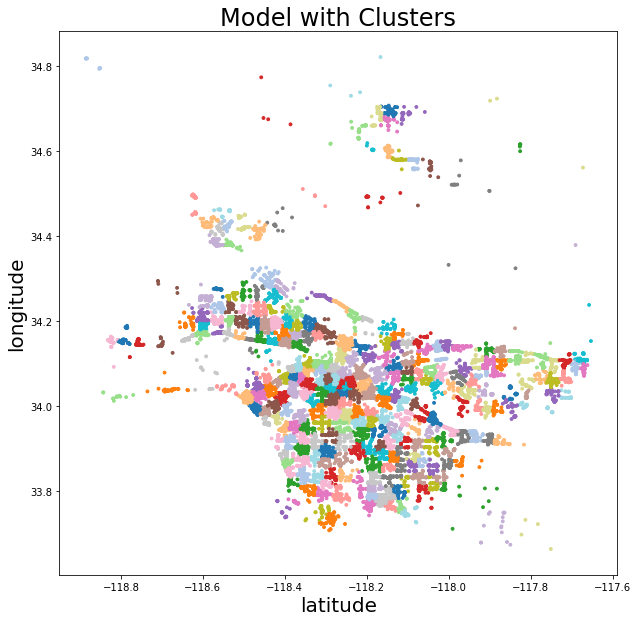

In [130]:
plt.figure(figsize=(10, 10))
plt.scatter(df.longitude, df.latitude, c=km.labels_, s=8, cmap="tab20")
plt.xlabel("latitude", fontsize = 20)
plt.ylabel("longitude", fontsize = 20)
plt.title('Model with Clusters', fontsize = 24);

In [131]:
Z_cluster = pd.concat([Z_train,Z_test],axis = 0, sort = False)
Z_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_294,cluster_295,cluster_296,cluster_297,cluster_298,cluster_299,price,review_count,rating,price_adj
18413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.197074,-0.103384,-0.562599
14782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.165788,0.513285,-0.577336
9960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,-0.283711,-1.336723,0.623610
3468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,0.828132,0.513285,0.413986
20005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.170601,0.513285,-1.288784


In [132]:
Z_cluster.sort_index()
Z_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_294,cluster_295,cluster_296,cluster_297,cluster_298,cluster_299,price,review_count,rating,price_adj
18413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.197074,-0.103384,-0.562599
14782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.165788,0.513285,-0.577336
9960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,-0.283711,-1.336723,0.623610
3468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.889436,0.828132,0.513285,0.413986
20005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.836631,-0.170601,0.513285,-1.288784


In [133]:
Z_cluster = pd.concat([df['zip_code'], Z_cluster.sort_index()], axis=1)

In [134]:
Z_cluster['zip_code'] = Z_cluster['zip_code'].astype(int)

In [135]:
Z_cluster = Z_cluster.astype(float)

In [136]:
Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012].values

array([[0.        , 0.        , 0.        , 0.        , 0.8427673 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00314465, 0.00314465, 0.        ,
        0.        , 0.03144654, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00314465, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [162]:
len(list(Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012]))

304

In [164]:
len(list(Z_train.columns))

304

In [138]:
bleh = Z_cluster.pivot_table(index='zip_code')[Z_cluster.pivot_table(index='zip_code').index == 90012].values

In [165]:
test_model.predict(bleh)

array([98382.47688809])

In [143]:
Z_cluster['zip_code'] = Z_cluster['zip_code'].astype(int)
Z_cluster = Z_cluster.pivot_table(index='zip_code')

In [144]:
Z_cluster.to_csv('../data/Z_cluster.csv', index=True)

In [45]:
lr.coef_

array([-1.45139458e+04,  9.88163569e+03,  1.44374270e+04,  2.49872908e+04,
        3.33403159e+04, -3.13005142e+04, -2.08267563e+04, -4.08333569e+04,
       -9.77879382e+03,  1.88881475e+04,  5.39097690e+02,  3.20916880e+03,
        4.33672150e+04, -2.11042900e+04, -2.17140656e+04,  2.94385017e+04,
       -1.59584415e+04,  2.40872327e+04,  1.56050358e+04,  9.46470362e+03,
       -1.08032551e+03, -3.01484306e+04,  5.45363816e+03,  2.85212953e+04,
       -9.16359178e+03, -2.82177699e+04,  1.33230642e+04, -3.14608665e+04,
       -2.99148309e+04,  1.29395464e+04,  3.25676579e+04, -2.80881577e+04,
       -3.10983550e+04, -9.68894335e+03, -1.64649616e+04,  2.08069697e+04,
        1.92070365e+03,  1.30221355e+03, -2.61395232e+03,  6.73376915e+03,
        1.36410337e+04, -3.49471165e+03, -1.71186884e+04,  6.64030932e+04,
       -2.89454173e+04,  1.23453369e+04, -1.98429257e+04,  7.45636200e+03,
       -3.75951529e+04,  6.48296559e+03,  7.72206771e+03, -4.33635424e+03,
       -7.01959960e+03,  

In [46]:
df.pivot_table(index='zip_code')[df.pivot_table(index='zip_code').index == '90012']

,avg_agi,count,latitude,longitude,med_agi,price,rating,review_count
zip_code,,,,,,,,
90012,61644,318,34.056503,-118.241029,38786,1.578616,3.746855,442.0


In [174]:
test_model = pickle.load(open('../flask_app_complete/model.p','rb'))

In [159]:
test_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [166]:
y_pred_2 = test_model.predict(Z_test)

In [167]:
residuals_2 = y_test - y_pred_2

Text(0.5, 1.0, 'Residual Mean')

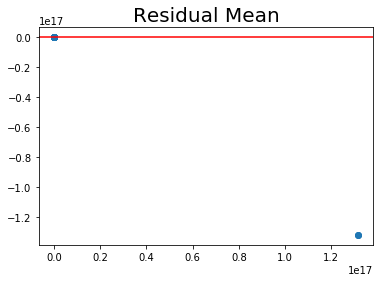

In [168]:
plt.scatter(y_pred_2, residuals_2)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)

In [ ]:
Z_cluster.drop()

In [171]:
def affluency_predictor(to_predict):
    
    # format the variable
    session_int = int(to_predict.strip())
    
    df = pd.read_csv("../Data/Z_cluster.csv")
    
    df = df[['zip_code',
             'cluster_0',
             'cluster_1',
             'cluster_2',
             'cluster_3',
             'cluster_4',
             'cluster_5',
             'cluster_6',
             'cluster_7',
             'cluster_8',
             'cluster_9',
             'cluster_10',
             'cluster_11',
             'cluster_12',
             'cluster_13',
             'cluster_14',
             'cluster_15',
             'cluster_16',
             'cluster_17',
             'cluster_18',
             'cluster_19',
             'cluster_20',
             'cluster_21',
             'cluster_22',
             'cluster_23',
             'cluster_24',
             'cluster_25',
             'cluster_26',
             'cluster_27',
             'cluster_28',
             'cluster_29',
             'cluster_30',
             'cluster_31',
             'cluster_32',
             'cluster_33',
             'cluster_34',
             'cluster_35',
             'cluster_36',
             'cluster_37',
             'cluster_38',
             'cluster_39',
             'cluster_40',
             'cluster_41',
             'cluster_42',
             'cluster_43',
             'cluster_44',
             'cluster_45',
             'cluster_46',
             'cluster_47',
             'cluster_48',
             'cluster_49',
             'cluster_50',
             'cluster_51',
             'cluster_52',
             'cluster_53',
             'cluster_54',
             'cluster_55',
             'cluster_56',
             'cluster_57',
             'cluster_58',
             'cluster_59',
             'cluster_60',
             'cluster_61',
             'cluster_62',
             'cluster_63',
             'cluster_64',
             'cluster_65',
             'cluster_66',
             'cluster_67',
             'cluster_68',
             'cluster_69',
             'cluster_70',
             'cluster_71',
             'cluster_72',
             'cluster_73',
             'cluster_74',
             'cluster_75',
             'cluster_76',
             'cluster_77',
             'cluster_78',
             'cluster_79',
             'cluster_80',
             'cluster_81',
             'cluster_82',
             'cluster_83',
             'cluster_84',
             'cluster_85',
             'cluster_86',
             'cluster_87',
             'cluster_88',
             'cluster_89',
             'cluster_90',
             'cluster_91',
             'cluster_92',
             'cluster_93',
             'cluster_94',
             'cluster_95',
             'cluster_96',
             'cluster_97',
             'cluster_98',
             'cluster_99',
             'cluster_100',
             'cluster_101',
             'cluster_102',
             'cluster_103',
             'cluster_104',
             'cluster_105',
             'cluster_106',
             'cluster_107',
             'cluster_108',
             'cluster_109',
             'cluster_110',
             'cluster_111',
             'cluster_112',
             'cluster_113',
             'cluster_114',
             'cluster_115',
             'cluster_116',
             'cluster_117',
             'cluster_118',
             'cluster_119',
             'cluster_120',
             'cluster_121',
             'cluster_122',
             'cluster_123',
             'cluster_124',
             'cluster_125',
             'cluster_126',
             'cluster_127',
             'cluster_128',
             'cluster_129',
             'cluster_130',
             'cluster_131',
             'cluster_132',
             'cluster_133',
             'cluster_134',
             'cluster_135',
             'cluster_136',
             'cluster_137',
             'cluster_138',
             'cluster_139',
             'cluster_140',
             'cluster_141',
             'cluster_142',
             'cluster_143',
             'cluster_144',
             'cluster_145',
             'cluster_146',
             'cluster_147',
             'cluster_148',
             'cluster_149',
             'cluster_150',
             'cluster_151',
             'cluster_152',
             'cluster_153',
             'cluster_154',
             'cluster_155',
             'cluster_156',
             'cluster_157',
             'cluster_158',
             'cluster_159',
             'cluster_160',
             'cluster_161',
             'cluster_162',
             'cluster_163',
             'cluster_164',
             'cluster_165',
             'cluster_166',
             'cluster_167',
             'cluster_168',
             'cluster_169',
             'cluster_170',
             'cluster_171',
             'cluster_172',
             'cluster_173',
             'cluster_174',
             'cluster_175',
             'cluster_176',
             'cluster_177',
             'cluster_178',
             'cluster_179',
             'cluster_180',
             'cluster_181',
             'cluster_182',
             'cluster_183',
             'cluster_184',
             'cluster_185',
             'cluster_186',
             'cluster_187',
             'cluster_188',
             'cluster_189',
             'cluster_190',
             'cluster_191',
             'cluster_192',
             'cluster_193',
             'cluster_194',
             'cluster_195',
             'cluster_196',
             'cluster_197',
             'cluster_198',
             'cluster_199',
             'cluster_200',
             'cluster_201',
             'cluster_202',
             'cluster_203',
             'cluster_204',
             'cluster_205',
             'cluster_206',
             'cluster_207',
             'cluster_208',
             'cluster_209',
             'cluster_210',
             'cluster_211',
             'cluster_212',
             'cluster_213',
             'cluster_214',
             'cluster_215',
             'cluster_216',
             'cluster_217',
             'cluster_218',
             'cluster_219',
             'cluster_220',
             'cluster_221',
             'cluster_222',
             'cluster_223',
             'cluster_224',
             'cluster_225',
             'cluster_226',
             'cluster_227',
             'cluster_228',
             'cluster_229',
             'cluster_230',
             'cluster_231',
             'cluster_232',
             'cluster_233',
             'cluster_234',
             'cluster_235',
             'cluster_236',
             'cluster_237',
             'cluster_238',
             'cluster_239',
             'cluster_240',
             'cluster_241',
             'cluster_242',
             'cluster_243',
             'cluster_244',
             'cluster_245',
             'cluster_246',
             'cluster_247',
             'cluster_248',
             'cluster_249',
             'cluster_250',
             'cluster_251',
             'cluster_252',
             'cluster_253',
             'cluster_254',
             'cluster_255',
             'cluster_256',
             'cluster_257',
             'cluster_258',
             'cluster_259',
             'cluster_260',
             'cluster_261',
             'cluster_262',
             'cluster_263',
             'cluster_264',
             'cluster_265',
             'cluster_266',
             'cluster_267',
             'cluster_268',
             'cluster_269',
             'cluster_270',
             'cluster_271',
             'cluster_272',
             'cluster_273',
             'cluster_274',
             'cluster_275',
             'cluster_276',
             'cluster_277',
             'cluster_278',
             'cluster_279',
             'cluster_280',
             'cluster_281',
             'cluster_282',
             'cluster_283',
             'cluster_284',
             'cluster_285',
             'cluster_286',
             'cluster_287',
             'cluster_288',
             'cluster_289',
             'cluster_290',
             'cluster_291',
             'cluster_292',
             'cluster_293',
             'cluster_294',
             'cluster_295',
             'cluster_296',
             'cluster_297',
             'cluster_298',
             'cluster_299',
             'price',
             'review_count',
             'rating',
             'price_adj']]
   
    # create array from dataframe row
    predict_array = df[df['zip_code'] == session_int].drop(columns='zip_code', axis=1)
    print(predict_array)
    # load trained model
    loaded_model = pickle.load(open('../flask_app_complete/model_j.p','rb'))
    # predict
    result = loaded_model.predict(predict_array)
    print(result)
    print('------------')
    
    map_df = pd.read_csv('../data/data_zipcode_j.csv')
    la_coord = (34.0522, -118.2437)
    maps = folium.Map(location=la_coord, zoom_start=11)
    
    for each in map_df.iterrows():
        if int(each[1]['zip_code']) == session_int:
            popup_text = folium.Html(f""" 
                <strong>Zip Code: {each[1]["zip_code"].astype(int)}</strong> 
                </br>Med. IRS Income (Thousands): {each[1]["med_agi"].round(3)}
                </br>Predicted Income Thousands: {result[0].round(3)}
                </br>Avg. $ of Businesses: {each[1]["price"].round(3)}
                </br> Number of Businesses: {int(each[1]["count"])}""",
                script=True)
            
            popup = folium.Popup(popup_text, max_width=2650, show=True)

            coord = (each[1]['latitude'],each[1]['longitude'])
            
            maps = folium.Map(location=coord, zoom_start=13)
            
            
            folium.Marker(
                location = [each[1]['latitude'],each[1]['longitude']],
                popup=popup,
                clustered_marker = True).add_to(maps)
            
    

    return maps

In [172]:
affluency_predictor('90005')

   cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
4        0.0        0.0        0.0        0.0        0.0        0.0   

   cluster_6  cluster_7  cluster_8  cluster_9  ...  cluster_294  cluster_295  \
4        0.0        0.0        0.0        0.0  ...          0.0          0.0   

   cluster_296  cluster_297  cluster_298  cluster_299     price  review_count  \
4          0.0          0.0          0.0     0.047619  0.267112      0.275698   

     rating  price_adj  
4  0.165098   0.057193  

[1 rows x 304 columns]
[40791.62091924]
------------


In [ ]:
# https://stackoverflow.com/questions/49735683/
df_2 = df_2.groupby('zip_code').filter(lambda x : len(x) > 1)

In [ ]:
train, test = category_pricer(df_2, state=111)

In [ ]:
train['zip_code'].dtype

In [ ]:
drop_columns = ['id', 'city', 'alias', 'med_agi', 'avg_agi', 'count']

X_train = train.drop(columns=drop_columns)
y_train = train['med_agi']

In [ ]:
df_pivot = df_2.pivot_table(index=['zip_code'])
df_pivot['price*review_count'] = df_pivot['price']*df_pivot['review_count']
df_pivot

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
train_pivot = train.pivot_table(index = ['zip_code'])
train_pivot['price*review_count'] = train_pivot['price']*df_pivot['review_count']
train_pivot.head()

In [ ]:
lr = LinearRegression()

In [ ]:
plt.scatter(x=train_pivot['price_sc'], y=train_pivot['avg_agi'])

In [ ]:
lr.fit(train_pivot[['price_sc']], train_pivot['avg_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_sc']], train_pivot['avg_agi'], sample_weight=train_pivot['count']))

In [ ]:
plt.scatter(x=train_pivot['price_adj'], y=train_pivot['avg_agi'])

In [ ]:
lr.fit(train_pivot[['price_adj']], train_pivot['avg_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_adj']], train_pivot['avg_agi'], sample_weight=train_pivot['count']))

In [ ]:
plt.scatter(x=train_pivot['price_sc'], y=train_pivot['med_agi'])

In [ ]:
lr.fit(train_pivot[['price_sc']], train_pivot['med_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_sc']], train_pivot['med_agi'], sample_weight=train_pivot['count']))

In [ ]:
plt.scatter(x=train_pivot['price_adj'], y=train_pivot['med_agi'])

In [ ]:
lr.fit(train_pivot[['price_adj']], train_pivot['med_agi'], sample_weight=train_pivot['count'])
print(lr.score(train_pivot[['price_adj']], train_pivot['med_agi'], sample_weight=train_pivot['count']))

In [ ]:
test_pivot = test.pivot_table(index = ['zip_code'])
test_pivot['price*review_count'] = test_pivot['price']*df_pivot['review_count']
test_pivot.head()

## trying different models

In [ ]:
X_train = train_pivot.drop(columns=['avg_agi', 'latitude', 'longitude', 'med_agi'])
y_train_avg = train_pivot['avg_agi']
y_train_med = train_pivot['med_agi']

X_test = test_pivot.drop(columns=['avg_agi', 'latitude', 'longitude', 'med_agi'])
y_test_avg = test_pivot['avg_agi']
y_test_med = test_pivot['med_agi']

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_med)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train_med)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train_med)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train_med)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train_med)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train_med)

support_vector_reg = SVR()
support_vector_reg.fit(X_train, y_train_med)

In [ ]:
def rmse_score(model, X_train, X_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5

    return (rmse_train, rmse_test)

In [ ]:
rmse_score(linear_reg, X_train, X_test, y_train_med, y_test_med)

In [ ]:
print(linear_reg.score(X_train, y_train_med))
print(linear_reg.score(X_test, y_test_med))

## clustering

In [ ]:
def get_coordinates(zipcode):
    '''
    Converts a five-digit USPS zip code to geographic coordinates.
    
    Arguments:
        zipcode:            a five-digit string or integer
        
    Returns:
        a tuple containing (longitude, latitude), in decimal degrees
    ''' 
    zipcode = str(zipcode)
    zip_coords = json.loads(open('../Assets/zip_code_coordinates.json').read())
    if len(zipcode) == 5 and zipcode.isnumeric():
        latitude = zip_coords[zipcode]['latitude']
        longitude = zip_coords[zipcode]['longitude']
        
    return longitude, latitude

In [ ]:
transfer_tune_iterator(X, y, range(20, 50, 1))

## median agi

In [ ]:
X_train = train_pivot.drop(columns=['avg_agi','med_agi','latitude','longitude'])
#features = list(X.columns)
y_train = df_dummy['med_agi']

In [ ]:
X_test = test_pivot.drop(columns=['avg_agi','med_agi','latitude','longitude'])
#features = list(X.columns)
y_test = df_dummy['med_agi']

In [ ]:
def pipeliner(transformer, estimator):
    
    # these dictionaries will allow us to pass string arguments in order to instantiate different objects
    trans_dict = {
        'cvect': CountVectorizer(),
        'tvect': TfidfVectorizer()
    }
    
    est_dict = {
        'mnb': MultinomialNB(),
        'logreg': LogisticRegression(solver='saga'),
        'rand': RandomForestClassifier(n_estimators=10),
        'extra': ExtraTreesClassifier(n_estimators=10)
    }
    
    # this is the actual pipeline object
    pipe = Pipeline([
        (transformer, eval(f'trans_dict["{transformer}"]')),
        ('dense', DenseTransformer()),
        (estimator, eval(f'est_dict["{estimator}"]'))
    ])
    
    return pipe

In [ ]:
def fit_grid_and_track(pipe, split, feature, params, twox, score_df):
    
    t = time.time()
    
    x_train, x_test, y_train, y_test = split
    
    # this condition allows us to calculate top features for the 0 class
    if not twox:
        y_train = 1 - y_train
        y_test = 1 - y_test
    
    # instantiate gridsearch.
    grid = GridSearchCV(pipe, params, cv=5, n_jobs=4)
    grid.fit(x_train[feature], y_train)
    
    best = grid.best_estimator_
    bestparams = grid.best_params_
    train_score = best.score(x_train[feature], y_train)
    test_score = best.score(x_test[feature], y_test)
    
    t = time.time() - t
    
    # only print out stats for the 1 class so we can see what's going on
    if twox:
        
        results = {}
        
        # store each results dictionary into our score DataFrame
        pipe_name = '-'.join([step for step in best.named_steps if step != 'dense'])
        results['pipeline'] = pipe_name
        results['feature'] = feature
        results['params'] = bestparams
        results['test'] = test_score
        results['overfit'] = train_score - test_score
        
        score_df = score_df.append(results, ignore_index=True)
        print(f'{pipe_name}: {feature}  -- {t}')
        print(f'train score: {train_score}')
        print(f'test score: {test_score}')
        print('--------------------------')
        print()
        
    return (best, score_df)

In [ ]:
# this function puts everything together. 
# still unsure if it's more clear like this or as one gigantic function.
# you can be the judge

def pipe_gridder(transformer, estimator, x, y, feature, params, scores):
    
    split = train_test_split(x, y, stratify=y, random_state=111)
    
    pipe = pipeliner(transformer, estimator)
    
    return fit_grid_and_track(pipe, split, feature, params, 1, scores)[1]

## change the data set from restaurant based to zipcode based

In [ ]:
# df_pivot = df.pivot_table(index = ['zip_code'])
# df_pivot.head()

##  Create New column for the combo of Price*review_count

In [ ]:
# df_pivot['price*review_count'] = df_pivot['price']*df_pivot['review_count']

In [ ]:
# df_pivot.head()

## Breakdown the price from original Pivot table(average) to count how many we have for each price category

In [ ]:
# count_price = (pd.crosstab(df["zip_code"], df['price']))
# count_price.columns = ['price_1','price_2','price_3','price_4']
# count_price.head()

# Break Down for Rating column

In [ ]:
# count_rating = (pd.crosstab(df["zip_code"], df['rating']))
# count_rating.columns = ['rating_0.0','rating_1.0','rating_1.5','rating_2.0','rating_2.5','rating_3.0','rating_3.5','rating_4.0','rating_4.5','rating_5']
# count_rating.head()

## combine price and rating to zipcode file

In [ ]:
# df_count = pd.merge(count_price, count_rating, left_on = 'zip_code', right_on = 'zip_code')
# df_count.head()

In [ ]:
# df_count.shape

In [ ]:
# df_pivot.shape

## Below is the combined data for zipcode, price, and rating, without countvecrizer the catogory

In [ ]:
# df_dummy = pd.merge(df_pivot, df_count, on="zip_code")
# df_dummy.drop(columns = ['price','rating'] ,inplace = True)
# df_dummy.reset_index(inplace = True)
# df_dummy.head()

In [ ]:
# df_dummy['zip_code'] = df_dummy['zip_code'].astype(str)

In [ ]:
# df_dummy.dtypes

In [ ]:
#df_dummy = df_dummy[df_dummy['count']>=50]

# Making the category a matrix via countvectrizor 

In [ ]:
# cat_dict = df['category'].to_dict()

In [ ]:
# for i in cat_dict:
#     cat_dict[i] = cat_dict[i].replace('[', '')
#     cat_dict[i] = cat_dict[i].replace(']', '')
#     cat_dict[i] = cat_dict[i].replace('\'', '')
#     cat_dict[i] = cat_dict[i].split(', ')

In [ ]:
# df_cat = pd.DataFrame.from_dict(cat_dict, orient = 'index')
# df_cat.head()

In [ ]:
# df_cat['zip_code'] = df['zip_code']
# df_cat

In [ ]:
# # borrowwed from Erin Hwang 
# categories_df = df_cat.astype(str).groupby('zip_code').agg(lambda x: ' '.join(x.unique()))

In [ ]:
# ##borrowwed from Erin Hwang
# categories_df['cat_text_by_zip'] = categories_df[0] + ' ' + categories_df[1] + ' ' + categories_df[2] + ' ' + categories_df[3] + ' ' + categories_df[4]
# categories_df.head()

In [ ]:
# categories_df.loc['90001', 'cat_text_by_zip']

In [ ]:
# cvec = CountVectorizer()

In [ ]:
# categories_df.reset_index(inplace = True)

In [ ]:
# X = categories_df['cate_text_by_zip']
# y = categories_df['zip_code']

In [ ]:
# df_cate = pd.DataFrame(cvec.fit_transform(X).toarray(),
#                 columns=cvec.get_feature_names() ) #
# df_cate.head()

## save the data with countvecrizer

In [ ]:
# df = pd.concat([df_dummy, df_cate], axis=1, sort=False)
# df.head()

In [ ]:
# df.to_csv('../data/data_cv.csv')

In [ ]:
#count_price_rating = (pd.crosstab(df["zip_code"], df['price*rating']))
#count_price_rating.head()

In [ ]:
#numeric_data = df._get_numeric_data().columns

## Begin to Model

## Tried both data with vecorizer and without, turns out the data without vectorizer performs better, so I will stick with this one

## Jerry's way to countvectorizer

In [ ]:
#df_dummy

In [ ]:
#category_pricer(X,y,state=42)

In [ ]:
# numeric_data = df_dummy._get_numeric_data().columns
# X = df_dummy._get_numeric_data().drop(columns=['ave_agi','latitude','longitude'])
# features = list(X.columns)
# y = df_dummy['ave_agi']
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# X_poly = poly.fit_transform(X)
# X_poly_train,X_poly_test,y_train,y_test = train_test_split(X_poly,y, random_state = 42)
# ss=StandardScaler()
# ss.fit(X_poly_train)
# X_train_sc=ss.transform(X_poly_train)
# X_test_sc = ss.transform(X_poly_test)
# lm = LinearRegression()
# lm.fit(X_train_sc, y_train)
# l_alpha = np.logspace(-1, 2, 100)
# lasso = LassoCV(alphas=l_alpha, cv=5, max_iter=1000)
# lasso.fit(X_train_sc, y_train)


In [ ]:
#lm.score(X_test_sc,y_test)

In [ ]:
#lasso.alpha_

In [ ]:
#lasso.score(X_test_sc, y_test)

In [ ]:
# coef_df = pd.DataFrame({"Predictor Variables":poly.get_feature_names(features),"Coef_weight":lasso.coef_,'absolute':abs(lasso.coef_)})
# coef_df.sort_values(by='absolute',ascending = False).head(20)

In [ ]:
#df_dummy['price*rating*price_3']=df_dummy['price*rating']*df_dummy['price_3']

In [ ]:
#df_dummy['price*review_count^2']=df_dummy['price*review_count']**2

In [ ]:
X = df_dummy.drop(columns=['ave_agi','latitude','longitude'])
#features = list(X.columns)
y = df_dummy['ave_agi']

In [ ]:
plt.hist(df["ave_agi"], bins=20);

In [ ]:
y = np.log(df_dummy["ave_agi"])  #y = np.log(df.copy()["ave_agi"])

In [ ]:
plt.hist(y, bins=20);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.3
)

In [ ]:
# sc = StandardScaler()  did not have significant impact
# X_train = sc.fit_transform(X_train)
# X_test =sc.transform(X_test)

# Trying different models
 - linear regression
 - knn regression
 - decision tree
 - bagging
 - random_forest
 - ada boost
 - support_vector

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

cart_reg = DecisionTreeRegressor()
cart_reg.fit(X_train, y_train)

bagged_reg = BaggingRegressor()
bagged_reg.fit(X_train, y_train)

random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)

adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train, y_train)

support_vector_reg = SVR()
support_vector_reg.fit(X_train, y_train)

# Evaluate our models

In [ ]:
def rmse_score(model, X_train, X_test, y_train, y_test):
    mse_train = mean_squared_error(y_true = y_train,
                                  y_pred = model.predict(X_train))
    mse_test = mean_squared_error(y_true = y_test,
                                  y_pred = model.predict(X_test))
    rmse_train = mse_train ** 0.5
    rmse_test = mse_test ** 0.5
    
    print("The training RMSE for " + str(model) + " is: " + str(rmse_train))
    print("The testing RMSE for " + str(model) + " is: " + str(rmse_test))
    return (rmse_train, rmse_test)

## Evaluate linear regression

In [ ]:
rmse_score(linear_reg, X_train, X_test, y_train, y_test)

In [ ]:
print(linear_reg.score(X_train, y_train))
print (linear_reg.score(X_test, y_test))

## Evaluate Knn

In [ ]:
rmse_score(knn_reg, X_train, X_test, y_train, y_test)

In [ ]:
print(knn_reg.score(X_train, y_train))
print (knn_reg.score(X_test, y_test))

## Evaluate decision tree

In [ ]:
rmse_score(cart_reg, X_train, X_test, y_train, y_test)

In [ ]:
print(cart_reg.score(X_train, y_train))
print (cart_reg.score(X_test, y_test))

## Evaluate Bagging model

In [ ]:
rmse_score(bagged_reg, X_train, X_test, y_train, y_test)

In [ ]:
print(bagged_reg.score(X_train, y_train))
print (bagged_reg.score(X_test, y_test))

## Evaluate random forest

In [ ]:
rmse_score(random_forest_reg, X_train, X_test, y_train, y_test)

In [ ]:
print(random_forest_reg.score(X_train, y_train))
print (random_forest_reg.score(X_test, y_test))

## Evaluate adaboost

In [ ]:
rmse_score(adaboost_reg, X_train, X_test, y_train, y_test)

In [ ]:
print(adaboost_reg.score(X_train, y_train))
print (adaboost_reg.score(X_test, y_test))

## Evaluate Support vector regression

In [ ]:
rmse_score(support_vector_reg, X_train, X_test, y_train, y_test)

In [ ]:
print(support_vector_reg.score(X_train, y_train))
print (support_vector_reg.score(X_test, y_test))

## Test Model with pipelines

In [ ]:
pipe = Pipeline([
    ('linear', LinearRegression())
])

pipe_params = {
                 'linear__fit_intercept': [True,False], 
                 'linear__normalize': [True, False],
                 'linear__copy_X': [True, False],
                 'linear__n_jobs': [1,5,10]
}

pipe_gridsearch = GridSearchCV(pipe, 
                                 pipe_params, 
                                 cv=5, 
                                 verbose=1)
pipe_gridsearch.fit(X_train, y_train);
print(pipe_gridsearch.best_score_)
pipe_gridsearch.best_estimator_

In [ ]:
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), 
                              knn_params, 
                              cv=5, 
                              verbose=1)
knn_gridsearch.fit(X_train, y_train);
best_knn = knn_gridsearch.best_estimator_
best_knn.score(X_test, y_test)

In [ ]:
cart_params = {
    'max_depth': [15,25,50]
    
}
cart_gridsearch = GridSearchCV(DecisionTreeRegressor(), 
                              cart_params, 
                              cv=5, 
                              verbose=1)
cart_gridsearch.fit(X_train, y_train);
best_cart = cart_gridsearch.best_estimator_
best_cart.score(X_test, y_test)

In [ ]:
BaggingRegressor()

In [ ]:
bag_params = {
    'n_estimators': [120,140,160],
    
    
}
bag_gridsearch = GridSearchCV(BaggingRegressor(),
                              bag_params,
                              cv=5, 
                              verbose=1)
bag_gridsearch.fit(X_train, y_train);
best_bag = bag_gridsearch.best_estimator_
print (best_bag)
best_bag.score(X_test, y_test)

In [ ]:
rf_params = {
    'n_estimators': [100,110,120],
    'max_depth':[6,7,8,9]
    
    
}
rf_gridsearch = GridSearchCV(RandomForestRegressor(), 
                              rf_params,
                              cv=5, 
                              verbose=1)
rf_gridsearch.fit(X_train, y_train);
best_rf = rf_gridsearch.best_estimator_
print (best_rf)
best_rf.score(X_test, y_test)

In [ ]:
AdaBoostRegressor()

In [ ]:
ada_params = {
    'n_estimators': [75,85,90]
}
ada_gridsearch = GridSearchCV(AdaBoostRegressor(), 
                              ada_params, 
                              cv=5, 
                              verbose=1)
ada_gridsearch.fit(X_train, y_train);
best_ada = ada_gridsearch.best_estimator_
print (best_ada)
best_ada.score(X_test, y_test)

In [ ]:
svr_params = {
    'degree': [2,3]
}
svr_gridsearch = GridSearchCV(SVR(), 
                              svr_params, 
                              cv=5, 
                              verbose=1)
svr_gridsearch.fit(X_train, y_train);
best_svr = svr_gridsearch.best_estimator_
print (best_svr)
best_svr.score(X_test, y_test)

|model|RMSE Train|RMSE Test|R2 Train|R2 Test|pipeline R2 test|
| --- | --- | --- | --- | ---|---|
|Linear Regression| 0.414|0.44|0.54|0.56|0.43|
|KNN Regression| 0.39|0.51|0.56|0.31|0.33|
|Decision Tree Regression| 8.11e05|0.56|0.99|0.16|0.03|
|Baggin Regression| 0.19|0.46|0.89|0.45|0.54|
|Random Forest Regression| 0.17|0.42|0.92|0.53|0.536|
|Adaboost Regression| 0.29|0.42|0.77|0.53|0.543|
|support vector Regression| 0.17|0.62|0.92|-0.02|-0.02|

# Using KMean Cluster to group Zipcodes

In [ ]:
def transfer_tune(X, y, k):
    location_data = df_dummy[["latitude", "longitude"]]
    km = KMeans(n_clusters=k,random_state = 42 )
    km.fit(location_data)
    X.loc[:, "cluster"] = km.predict(location_data)
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
    )
    adaboost_reg.fit(X_train, y_train)
    r2 =adaboost_reg.score(X_test, y_test)
    print(f"{k} : {r2}")

In [ ]:
for k in range(20, 50, 1):
    transfer_tune(X, y, k)

In [ ]:
location_data = df_dummy[["latitude", "longitude"]]
km = KMeans(n_clusters=39, random_state = 42)
km.fit(location_data)
X.loc[:, "cluster"] = km.predict(location_data)
X_dummy = pd.get_dummies(columns=["cluster"], data=X)
X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.3
)

adaboost_reg.fit(X_train, y_train)
r2 = adaboost_reg.score(X_test, y_test)
print (r2)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(df_dummy.latitude, df_dummy.longitude, c=km.labels_, s=8, cmap="tab20")
plt.xlabel("latitude", fontsize = 20)
plt.ylabel("longitude", fontsize = 20)
plt.title('Model with Clusters', fontsize = 24);

In [ ]:
X_cluster = pd.concat([X_train,X_test],axis = 0, sort = False)

In [ ]:
X_cluster.to_csv('../data/X_cluster.csv')

In [ ]:
y_pred = adaboost_reg.predict(X_test)

In [ ]:
y_pred

In [ ]:
df_dummy['pred']=adaboost_reg.predict(X_cluster)

In [ ]:
df_dummy[df_dummy['zip_code']=='90015']

In [ ]:
residuals = y_test - y_pred

In [ ]:
residuals.sort_values()

In [ ]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r')
plt.title('Residual Mean',size = 20)
#plt.savefig('./plots/residual.png')

In [ ]:

plt.figure(figsize=(12,9))
plt.rc('font', size=22)
# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_pred, y_test, s=5, alpha = 0.5)

# Plot a line.
plt.plot([3, np.max(y_test)],
         [3, np.max(y_test)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

In [ ]:
pickle.dump(linear_reg, open('../flask_app_complete/model.p', 'wb'))